# Baseline CNN on CIFAR-10

## Purpose
This notebook establishes a baseline CNN performace on CIFAR-10 classification without regularization. The goal is to provide a benchmark against which dropout variants will be compared.
The architecture choice is simple as the main aim is to observe the effects of regularization techniques on CNNs.

In [1]:
import os
import sys

current_dir = os.getcwd()
package_path = os.path.abspath(os.path.join(current_dir, '..'))

if package_path not in sys.path:
    sys.path.insert(0, package_path)

In [2]:
# importing all necessary libs and modules.
import torch
from PIL import Image
import matplotlib.pyplot as plt

from config.paths import PathConfig # Path config

from src.model import MiniCNN, ConvBlock, FCBlock
from src.train import trainModel
from src.data import CustomDataset, load_cifar_10_data, check_data_loading, Loader, class_to_idx
from src.visualizations import plotFmaps_and_activationHist, plotCurves
from src.utils import unpickle, loadWeights, readJson, genError, saveHistory, evalModel

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
paths = PathConfig("regularization-ml", "regularization-data")
PROJECT_DIR = paths.project
DATA_DIR = paths.data
BASE_DIR = paths.root

## Dataset
The following method, loads the cifar-10 dataset and creates python lists of training, testing and validation data and labels.
We use the CIFAR-10 dataset (60, 000 32x32 images across 10 classes). A link to the dataset is provided in notebooks/README.md
- Training set: 40k images
- Test set: 10k images
- Validaiton set: 10k images

We apply only minimal preprocessing to the training set (normalization, randomCrop w/ padding=4, colorJitter, and randomHorizontalFlip w/ p=0.3)

In [ ]:
""" If using Colab, uncomment this
# Copy once from Drive
!cp $DATA_DIR/cifar-10-python.tar.gz /content/

# Extract locally
!mkdir /content/dataset/
!tar -xzf /content/cifar-10-python.tar.gz -C /content/dataset/
"""

In [ ]:
""" If running on local, uncomment this
!mkdir $DATA_DIR/dataset/
!tar -xzf $DATA_DIR/cifar-10-python.tar.gz -C $DATA_DIR/dataset/
"""

In [5]:
LOCAL_DATA = f"{DATA_DIR}/dataset" # path to cifar-10 dataset
train_data, train_labels, val_data, val_labels, test_data, test_labels = load_cifar_10_data(LOCAL_DATA)

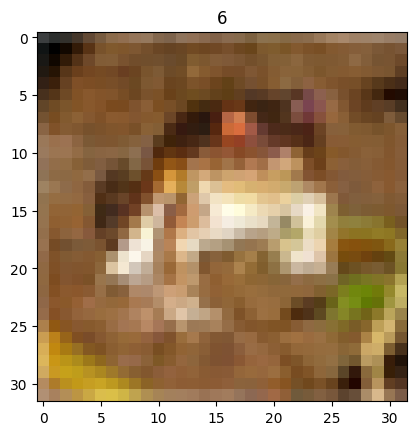

In [6]:
# Just sanity testing
image_array = val_data[0]
image_label = val_labels[0]
image = image_array.reshape(3, 32, 32)
image = Image.fromarray(image.transpose(1, 2, 0)) #HWC
plt.imshow(image)
plt.title(image_label)
plt.show() # The frog is frogging.

In [7]:
# Creates train, test, and val loaders
train_loader, val_loader, test_loader = Loader(train_data, train_labels, val_data, val_labels, test_data, test_labels)

Starting Data Loading...
⚠️  CUDA not available, using CPU
📁 Loading datasets...
✅ Datasets loaded successfully
Training samples: 40000
Validation samples: 10000
Batch size: 64
🔍 Testing data loading...
✅ Train batch shape: torch.Size([64, 3, 32, 32]), Labels: torch.Size([64])
   Input range: [-1.989, 2.126]
   Label range: [0, 9]
✅ Val batch shape: torch.Size([64, 3, 32, 32]), Labels: torch.Size([64])


## Model definition
This defines the baseline architecture as presented in the notebooks/README.md.
A lightweight CNN with;
- 4 conv layers
- 3 fully connected layers.
- ReLU activations and max-pooling.

This architecture is intentionally lightweight — the goal is **not state-of-the-art**, but a consistent baseline. This will serve as the control.

In [8]:
# Defining the layers for the baseline model
base_conv_layers = [
    ConvBlock(3, 64, pool=False),
    ConvBlock(64, 64),
    ConvBlock(64, 128, pool=False),
    ConvBlock(128, 128)
]

base_fc_layers = [
    FCBlock(128, 64),
    torch.nn.Linear(64, 10)
]

baseline_model = MiniCNN(base_conv_layers, base_fc_layers)

## Training Setup;
- Optimizer: AdamW (lr=1e-3, weight_decay=1e-3)
- Batch size = 64
- Loss: Cross-entropy
- The training loop contains and early stopping implementation based on patience=7 and the validation loss.
- The max_epochs for training is 70, but the baseline model stopped at 50 epochs due to early stopping.
- We also implement learning rate annealing using pytorch's lr_scheduler.

These hyperparameters are chosen to be reasonable defaults.

In [ ]:
"""
Uncomment only when you need to train the model
history_base = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
model_type = "baseline"
path = f"{DATA_DIR}/weights"
base_model = trainModel(baseline_model, history_base, train_loader, val_loader, model_type, path)
"""

In [ ]:
"""
Uncomment only when you want to push to git finally.
history_path = f"{DATA_DIR}/logs/baseline.json"
saveHistory(history_base, history_path) # Saves the training metadata to a json file
"""

## Results
We plot the training and validation loss and accuracy curves for the model, @ around epoch 40, the validation loss began to slowly plateau.

In [9]:
weights_path = f"{DATA_DIR}/weights/baseline.pth"
baseline_model = loadWeights(baseline_model, weights_path)

Model weights not found.


In [10]:
baseline_json = f"{DATA_DIR}/logs/baseline.json"
baseline_data = readJson(baseline_json) # method reads the training metadata from a json file.

#### Training and validation curves
As the baseline convnet trains for more epochs, the difference between train and val losses increases significantly, we will observe if regularization can mitigate this effect.

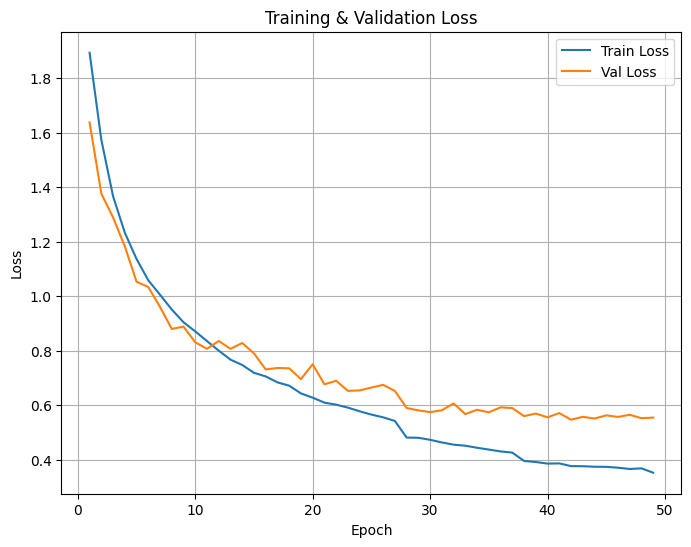

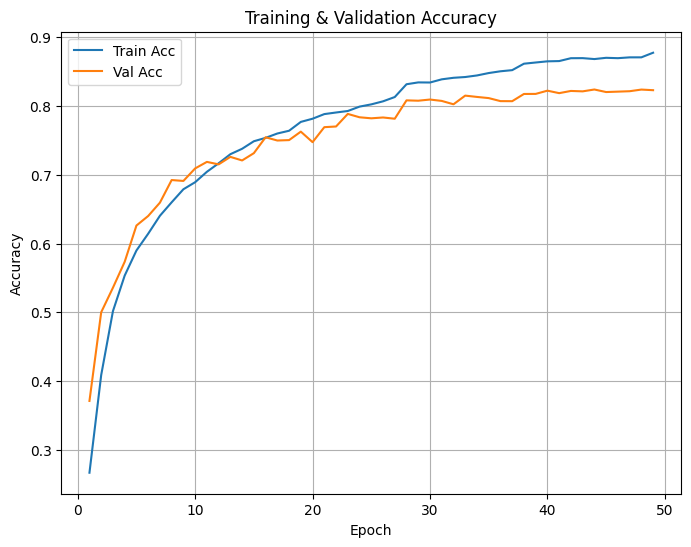

In [13]:
train_losses = baseline_data["train_loss"]
val_losses = baseline_data["val_loss"]
train_accs = baseline_data["train_acc"]
val_accs = baseline_data["val_acc"]
visualizations_folder = "../results/baseline"
plotCurves(train_losses, val_losses, train_accs, val_accs, visualizations_folder) # the last arg is where the image will be saved

#### Generalization Gap
We plot the estimated generalization gap of the distribution using the difference between the validation and training losses. This gives somewhat of a metric for overfitting.

Here the baseline exhibits a high, unstable generalization gap (wide shaded band); applying Dropout should lower the mean gap, indicating more consistent generalization.

---

Mean Gap: 0.0767

std: 0.1033

Min / max (range): [-0.26, 0.20]


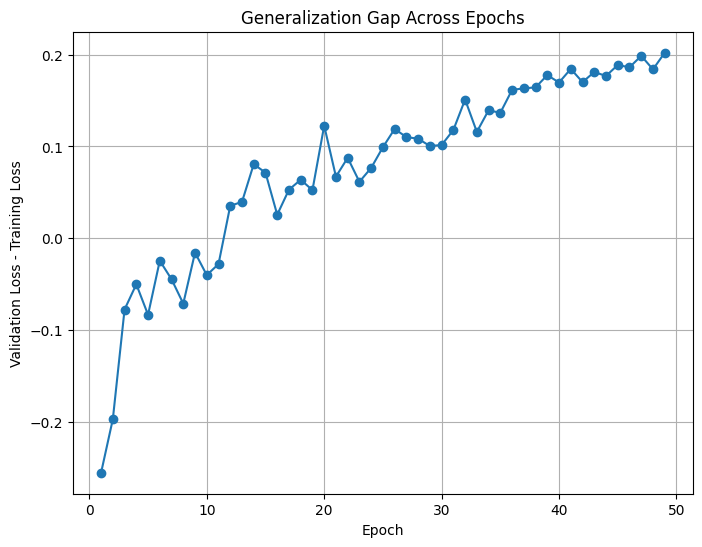

In [ ]:
genError(visualizations_folder, train_losses, val_losses)

Accuracy: 0.8176
              precision    recall  f1-score   support

           0     0.8088    0.8460    0.8270      1000
           1     0.9356    0.9000    0.9174      1000
           2     0.7646    0.6950    0.7281      1000
           3     0.7409    0.6290    0.6804      1000
           4     0.7921    0.7810    0.7865      1000
           5     0.6991    0.7830    0.7387      1000
           6     0.8268    0.8690    0.8474      1000
           7     0.8393    0.8670    0.8529      1000
           8     0.8968    0.9040    0.9004      1000
           9     0.8707    0.9020    0.8861      1000

    accuracy                         0.8176     10000
   macro avg     0.8175    0.8176    0.8165     10000
weighted avg     0.8175    0.8176    0.8165     10000

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequenti

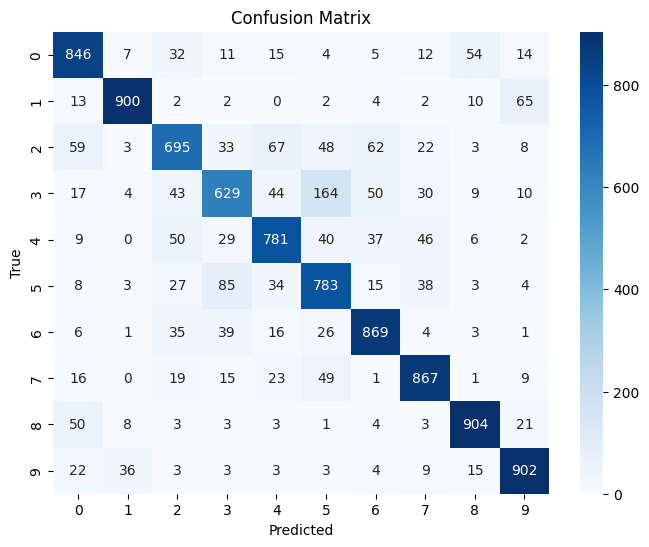

In [ ]:
evalModel(baseline_model, visualizations_folder, test_loader)

This baseline shows that the unregularized CNN reaches ~82.3% accuracy. In subsequent notebooks, we will test whether dropout improves generalization.

Final metrics:  
| Model     | Val Acc | Test Acc |  
|-----------|---------|----------|  
| Baseline  | 82.4%   | 81.8%    |  

## Conclusion
The baseline CNN achieves ~82.4% validation accuracy without any regularization.  
This performance will act as the reference point for later experiments testing dropout in different layers.  